# SARIMA Model for Precipitation Prediction

This notebook implements a SARIMA (Seasonal Autoregressive Integrated Moving Average) model for binary rain prediction in Bissau, Guinea-Bissau.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
)
from sktime.split import temporal_train_test_split

# SARIMA specific imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 100

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Data path
DATA_PATH = Path("../../0_data/bissau_merged.nc")

# Center cell indices (for 5x5 grid)
CENTER_LAT_IDX = 2
CENTER_LON_IDX = 2

# Rain threshold (mm)
RAIN_THRESHOLD = 0.1

print(f"Data path: {DATA_PATH}")
print(f"Rain threshold: {RAIN_THRESHOLD} mm")

Data path: ../../0_data/bissau_merged.nc
Rain threshold: 0.1 mm


In [3]:
# Load NetCDF4 with xarray
ds = xr.open_dataset(DATA_PATH)

# Convert timestamps to datetime
time_values = pd.to_datetime(ds.valid_time.values)

# Extract center cell data & apply unit conversions
t2m_center = ds.t2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
d2m_center = ds.d2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
tcc_center = ds.tcc[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 100  # fraction → %
sp_center = ds.sp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values / 100  # Pa → hPa
tp_center = ds.tp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 1000  # m → mm

# Create DataFrame with datetime index
df = pd.DataFrame(
    {
        "datetime": time_values,
        "t2m": t2m_center,  # Temperature (°C)
        "d2m": d2m_center,  # Dewpoint (°C)
        "tcc": tcc_center,  # Cloud cover (%)
        "sp": sp_center,  # Surface pressure (hPa)
        "tp": tp_center,  # Precipitation (mm)
    }
)
df.set_index("datetime", inplace=True)


# Calculate Relative Humidity using Magnus formula
def calc_relative_humidity(t2m, d2m):
    a, b = 17.625, 243.04
    rh = 100 * np.exp((a * d2m) / (b + d2m)) / np.exp((a * t2m) / (b + t2m))
    return np.clip(rh, 0, 100)


df["rh"] = calc_relative_humidity(df["t2m"].values, df["d2m"].values)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nBasic statistics:")
df.describe().round(2)

Data shape: (18263, 6)
Date range: 1975-01-01 00:00:00 to 2024-12-31 00:00:00

Basic statistics:


,t2m,d2m,tcc,sp,tp,rh
count,18263.00,18263.00,18263.00,18263.00,18263.00,18263.00
mean,24.93,20.85,56.09,1011.19,0.10,79.89
std,1.64,4.56,40.24,1.63,0.53,16.09
min,18.62,0.08,0.00,1005.20,0.00,21.22
25%,23.99,19.05,10.79,1010.07,0.00,74.01
50%,25.13,22.68,66.50,1011.18,0.00,86.25
75%,26.07,24.03,97.31,1012.32,0.00,91.38
max,31.38,27.67,100.00,1017.49,24.93,99.86


## Binarize Target Variable

Create binary target: Rain (tp > 0.1mm) vs No Rain


BINARY TARGET DISTRIBUTION (threshold: 0.1 mm)

No Rain (0): 16,284 days (89.2%)
Rain (1):    1,979 days (10.8%)

Class imbalance ratio: 8.23:1


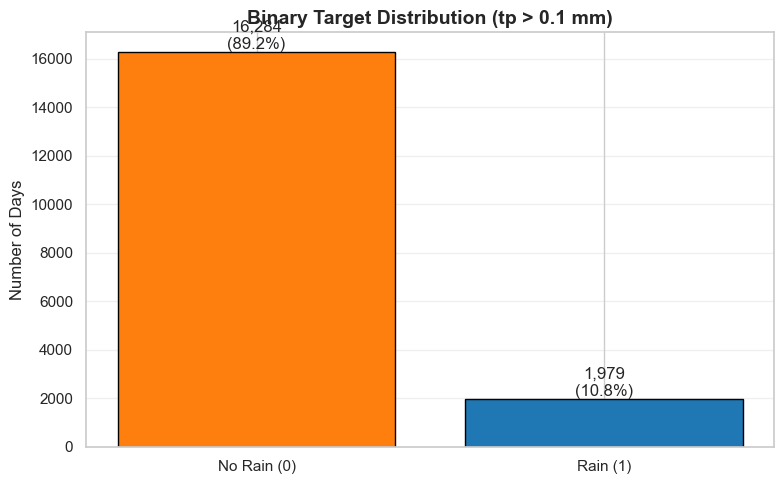

In [4]:
# Binarize precipitation: Rain vs No Rain
df["rain_binary"] = (df["tp"] > RAIN_THRESHOLD).astype(int)

# Check class distribution
class_counts = df["rain_binary"].value_counts()
class_pct = df["rain_binary"].value_counts(normalize=True) * 100

print("=" * 50)
print(f"BINARY TARGET DISTRIBUTION (threshold: {RAIN_THRESHOLD} mm)")
print("=" * 50)
print(f"\nNo Rain (0): {class_counts[0]:,} days ({class_pct[0]:.1f}%)")
print(f"Rain (1):    {class_counts[1]:,} days ({class_pct[1]:.1f}%)")
print(f"\nClass imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
colors = ["#ff7f0e", "#1f77b4"]
bars = ax.bar(
    ["No Rain (0)", "Rain (1)"], class_counts.values, color=colors, edgecolor="black"
)
ax.bar_label(
    bars,
    labels=[
        f"{c:,}\n({p:.1f}%)" for c, p in zip(class_counts.values, class_pct.values)
    ],
)
ax.set_ylabel("Number of Days")
ax.set_title(
    f"Binary Target Distribution (tp > {RAIN_THRESHOLD} mm)",
    fontsize=14,
    fontweight="bold",
)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Temporal Train/Val/Test Split (70/20/10)

Using sktime's `temporal_train_test_split` to preserve time ordering.


In [5]:
# For SARIMA, we work directly with the binary rain series
y = df["rain_binary"]

# Calculate split sizes
total = len(df)
train_size = int(total * 0.70)
val_size = int(total * 0.20)
test_size = total - train_size - val_size  # Remainder (~10%)

print(f"Total samples: {total:,}")
print(f"\nPlanned split:")
print(f"  Train: {train_size:,} ({train_size/total*100:.1f}%)")
print(f"  Val:   {val_size:,} ({val_size/total*100:.1f}%)")
print(f"  Test:  {test_size:,} ({test_size/total*100:.1f}%)")

Total samples: 18,263

Planned split:
  Train: 12,784 (70.0%)
  Val:   3,652 (20.0%)
  Test:  1,827 (10.0%)


In [6]:
# First split: train vs (val + test)
y_train, y_temp = temporal_train_test_split(y, test_size=(val_size + test_size))

# Second split: val vs test
y_val, y_test = temporal_train_test_split(y_temp, test_size=test_size)

print("=" * 60)
print("TEMPORAL SPLIT RESULTS")
print("=" * 60)
print(f"\nTrain set: {len(y_train):,} samples ({len(y_train)/total*100:.1f}%)")
print(f"  Date range: {y_train.index.min().date()} to {y_train.index.max().date()}")
print(f"  Rain days: {y_train.sum():,} ({y_train.mean()*100:.1f}%)")

print(f"\nValidation set: {len(y_val):,} samples ({len(y_val)/total*100:.1f}%)")
print(f"  Date range: {y_val.index.min().date()} to {y_val.index.max().date()}")
print(f"  Rain days: {y_val.sum():,} ({y_val.mean()*100:.1f}%)")

print(f"\nTest set: {len(y_test):,} samples ({len(y_test)/total*100:.1f}%)")
print(f"  Date range: {y_test.index.min().date()} to {y_test.index.max().date()}")
print(f"  Rain days: {y_test.sum():,} ({y_test.mean()*100:.1f}%)")

TEMPORAL SPLIT RESULTS

Train set: 12,784 samples (70.0%)
  Date range: 1975-01-01 to 2009-12-31
  Rain days: 1,388 (10.9%)

Validation set: 3,652 samples (20.0%)
  Date range: 2010-01-01 to 2019-12-31
  Rain days: 365 (10.0%)

Test set: 1,827 samples (10.0%)
  Date range: 2020-01-01 to 2024-12-31
  Rain days: 226 (12.4%)


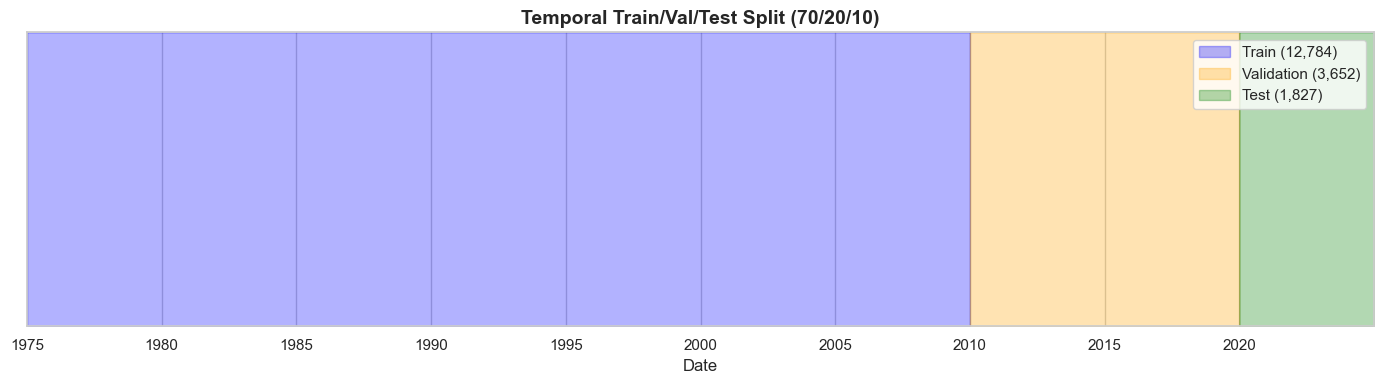

In [7]:
# Visualize the split
fig, ax = plt.subplots(figsize=(14, 4))

ax.fill_between(
    y_train.index, 0, 1, alpha=0.3, color="blue", label=f"Train ({len(y_train):,})"
)
ax.fill_between(
    y_val.index, 0, 1, alpha=0.3, color="orange", label=f"Validation ({len(y_val):,})"
)
ax.fill_between(
    y_test.index, 0, 1, alpha=0.3, color="green", label=f"Test ({len(y_test):,})"
)

ax.set_xlim(df.index.min(), df.index.max())
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xlabel("Date")
ax.set_title("Temporal Train/Val/Test Split (70/20/10)", fontsize=14, fontweight="bold")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Time Series Analysis

Analyze the autocorrelation structure and stationarity of the binary rain series to inform SARIMA parameter selection.

In [8]:
# Augmented Dickey-Fuller test for stationarity
def adf_test(series, name="Series"):
    """Perform ADF test and print results."""
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF Test for {name}")
    print("=" * 50)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Lags Used: {result[2]}")
    print(f"Number of Observations: {result[3]}")
    print("\nCritical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    print(f"\nConclusion: {'Stationary' if result[1] < 0.05 else 'Non-stationary'} (at 5% significance)")
    return result[1] < 0.05

# Test stationarity on training data
is_stationary = adf_test(y_train, "Binary Rain Series (Training)")

ADF Test for Binary Rain Series (Training)
ADF Statistic: -9.3714
p-value: 0.000000
Lags Used: 37
Number of Observations: 12746

Critical Values:
  1%: -3.4309
  5%: -2.8618
  10%: -2.5669

Conclusion: Stationary (at 5% significance)


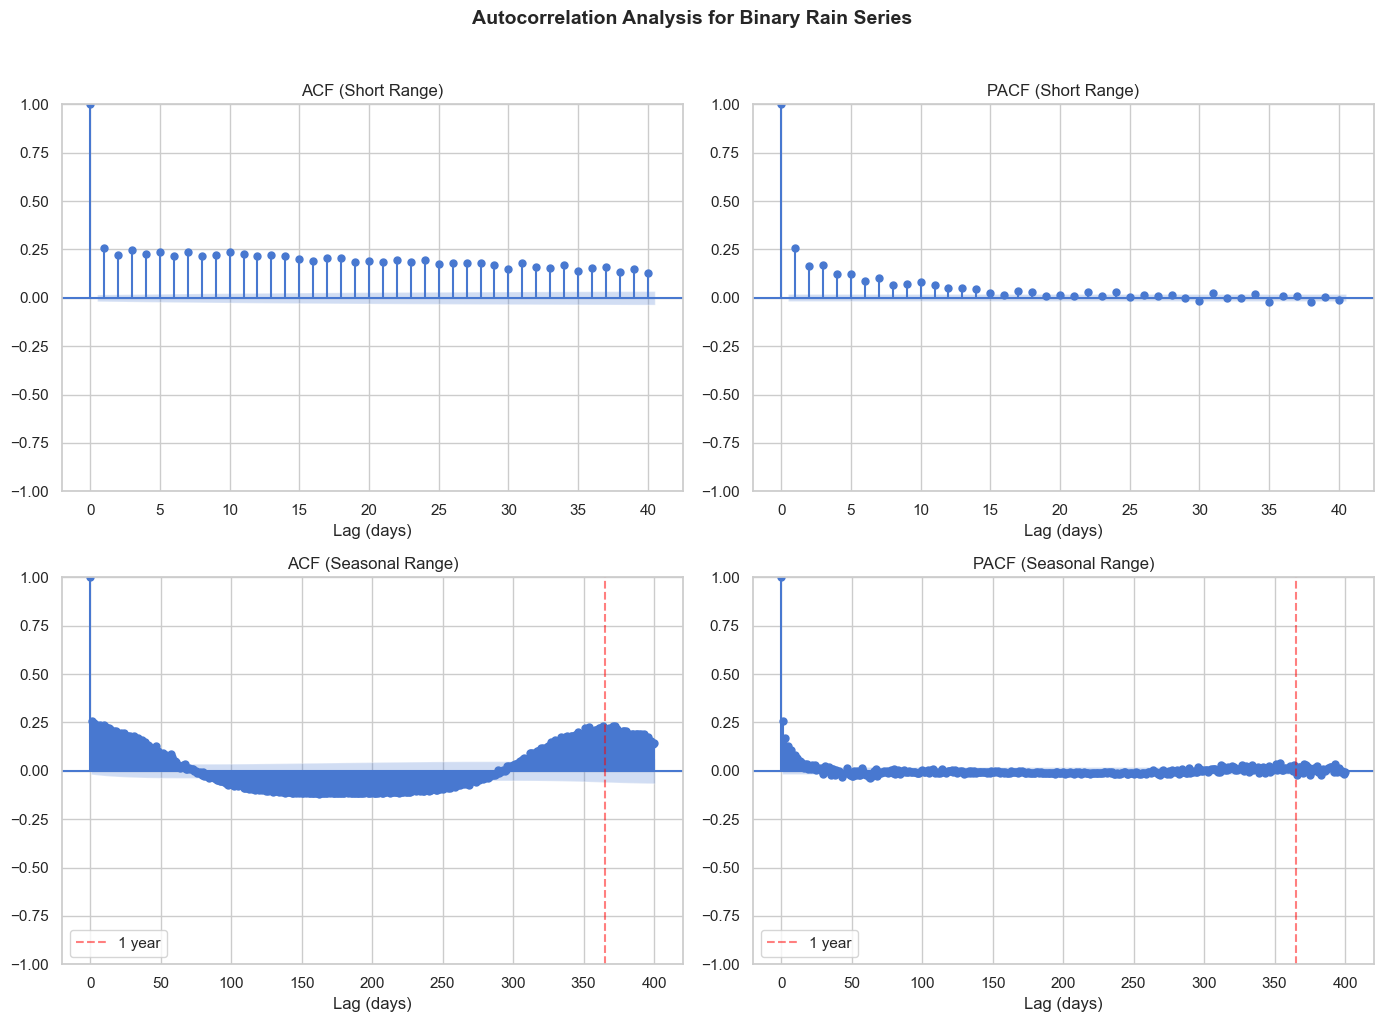


Interpretation:
- ACF shows how correlated the series is with its past values
- PACF shows direct correlation after removing intermediate lag effects
- Significant spikes at lag 365 indicate annual seasonality
- Use ACF for MA order (q), PACF for AR order (p)


In [9]:
# Plot ACF and PACF for training data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ACF - short range (for AR order)
plot_acf(y_train, lags=40, ax=axes[0, 0], title="ACF (Short Range)")
axes[0, 0].set_xlabel("Lag (days)")

# PACF - short range (for AR order)
plot_pacf(y_train, lags=40, ax=axes[0, 1], title="PACF (Short Range)", method='ywm')
axes[0, 1].set_xlabel("Lag (days)")

# ACF - seasonal range (for seasonal order, ~365 days)
plot_acf(y_train, lags=400, ax=axes[1, 0], title="ACF (Seasonal Range)")
axes[1, 0].set_xlabel("Lag (days)")
axes[1, 0].axvline(x=365, color='red', linestyle='--', alpha=0.5, label='1 year')
axes[1, 0].legend()

# PACF - seasonal range
plot_pacf(y_train, lags=400, ax=axes[1, 1], title="PACF (Seasonal Range)", method='ywm')
axes[1, 1].set_xlabel("Lag (days)")
axes[1, 1].axvline(x=365, color='red', linestyle='--', alpha=0.5, label='1 year')
axes[1, 1].legend()

plt.suptitle("Autocorrelation Analysis for Binary Rain Series", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- ACF shows how correlated the series is with its past values")
print("- PACF shows direct correlation after removing intermediate lag effects")
print("- Significant spikes at lag 365 indicate annual seasonality")
print("- Use ACF for MA order (q), PACF for AR order (p)")

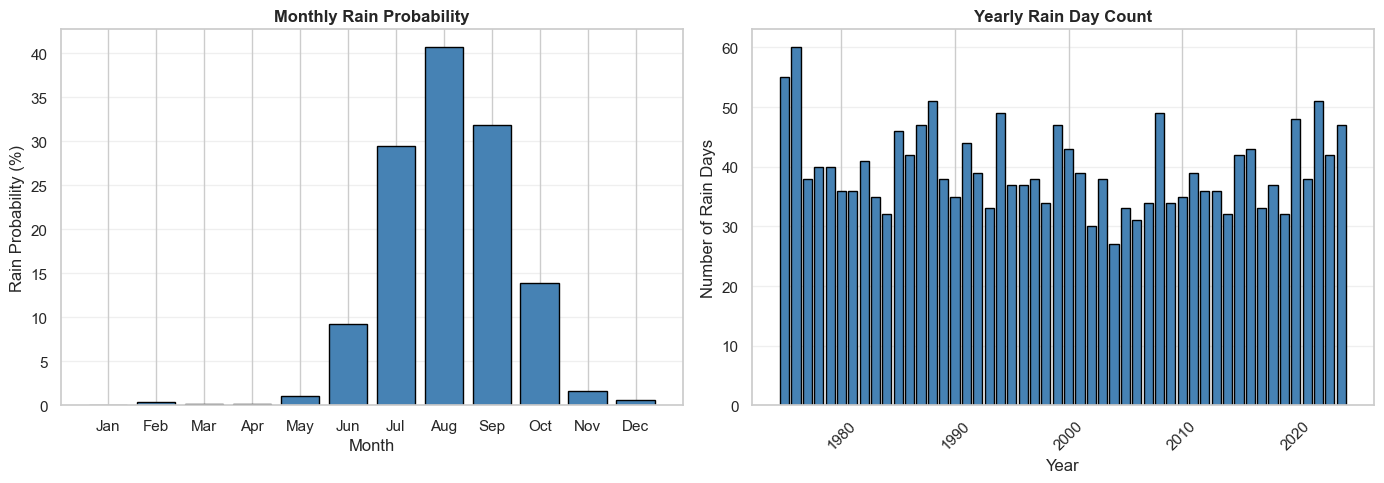


Seasonal Analysis:
  Driest month: Jan (0.1% rain probability)
  Wettest month: Aug (40.6% rain probability)


In [10]:
# Analyze seasonal patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Monthly rain probability
monthly_rain = df["rain_binary"].groupby(df.index.month).mean() * 100
axes[0].bar(range(1, 13), monthly_rain.values, color='steelblue', edgecolor='black')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Rain Probability (%)")
axes[0].set_title("Monthly Rain Probability", fontsize=12, fontweight="bold")
axes[0].grid(axis='y', alpha=0.3)

# Yearly rain count
yearly_rain = df["rain_binary"].groupby(df.index.year).sum()
axes[1].bar(yearly_rain.index, yearly_rain.values, color='steelblue', edgecolor='black')
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Number of Rain Days")
axes[1].set_title("Yearly Rain Day Count", fontsize=12, fontweight="bold")
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nSeasonal Analysis:")
print(f"  Driest month: {['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][monthly_rain.argmin()]} ({monthly_rain.min():.1f}% rain probability)")
print(f"  Wettest month: {['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][monthly_rain.argmax()]} ({monthly_rain.max():.1f}% rain probability)")

## SARIMA Model

Fit a SARIMA model to the binary rain series. Due to the strong annual seasonality and computational constraints, we'll use a simplified seasonal component with weekly seasonality (m=7) or monthly approximation.

**Note:** Full annual seasonality (m=365) is computationally expensive. We'll try different approaches:
1. SARIMA with weekly seasonality (m=7)
2. SARIMA with monthly approximation using exogenous variables

In [11]:
# Create Fourier features for annual seasonality (more efficient than m=365)
def create_fourier_features(index, period=365.25, n_harmonics=4):
    """Create Fourier terms to capture seasonal patterns."""
    t = np.arange(len(index))
    features = {}
    for k in range(1, n_harmonics + 1):
        features[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        features[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(features, index=index)

# Create Fourier features for train, val, and test
fourier_train = create_fourier_features(y_train.index, period=365.25, n_harmonics=4)
fourier_val = create_fourier_features(y_val.index, period=365.25, n_harmonics=4)
fourier_test = create_fourier_features(y_test.index, period=365.25, n_harmonics=4)

print("Fourier features created to capture annual seasonality")
print(f"  Number of harmonics: 4 (8 features)")
print(f"  Train shape: {fourier_train.shape}")
print(f"  Validation shape: {fourier_val.shape}")
print(f"  Test shape: {fourier_test.shape}")

Fourier features created to capture annual seasonality
  Number of harmonics: 4 (8 features)
  Train shape: (12784, 8)
  Validation shape: (3652, 8)
  Test shape: (1827, 8)


In [12]:
# Fit SARIMAX model with Fourier terms for seasonality
# Using ARIMA(p,d,q) with exogenous Fourier features

# SARIMA parameters - start with simple model
# p: AR order (autoregressive)
# d: Differencing order (for stationarity)
# q: MA order (moving average)

order = (2, 0, 2)  # ARIMA order - adjust based on ACF/PACF analysis

print("=" * 60)
print("FITTING SARIMAX MODEL WITH FOURIER SEASONALITY")
print("=" * 60)
print(f"\nOrder (p, d, q): {order}")
print("Exogenous variables: 4 Fourier harmonics (8 features)")
print("\nFitting model... (this may take a few minutes)")

# Fit the model
model = SARIMAX(
    y_train,
    exog=fourier_train,
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False, maxiter=500)
print("\nModel fitted successfully!")
print(model_fit.summary().tables[0])

FITTING SARIMAX MODEL WITH FOURIER SEASONALITY

Order (p, d, q): (2, 0, 2)
Exogenous variables: 4 Fourier harmonics (8 features)

Fitting model... (this may take a few minutes)

Model fitted successfully!
                               SARIMAX Results                                
Dep. Variable:            rain_binary   No. Observations:                12784
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1633.420
Date:                Tue, 06 Jan 2026   AIC                           3292.839
Time:                        09:54:34   BIC                           3389.764
Sample:                    01-01-1975   HQIC                          3325.252
                         - 12-31-2009                                         
Covariance Type:                  opg                                         



Model Coefficients:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         -0.1279      0.010    -12.259      0.000      -0.148      -0.107
cos_1         -0.1217      0.011    -11.046      0.000      -0.143      -0.100
sin_2          0.0989      0.011      8.680      0.000       0.077       0.121
cos_2         -0.0029      0.013     -0.226      0.821      -0.028       0.022
sin_3         -0.0227      0.011     -2.152      0.031      -0.043      -0.002
cos_3          0.0241      0.012      1.940      0.052      -0.000       0.049
sin_4          0.0006      0.008      0.085      0.932      -0.014       0.015
cos_4         -0.0033      0.007     -0.496      0.620      -0.016       0.010
ar.L1          0.2414      0.043      5.584      0.000       0.157       0.326
ar.L2          0.7585      0.043     17.547      0.000       0.674       0.843
ma.L1         -0.2065      0.04

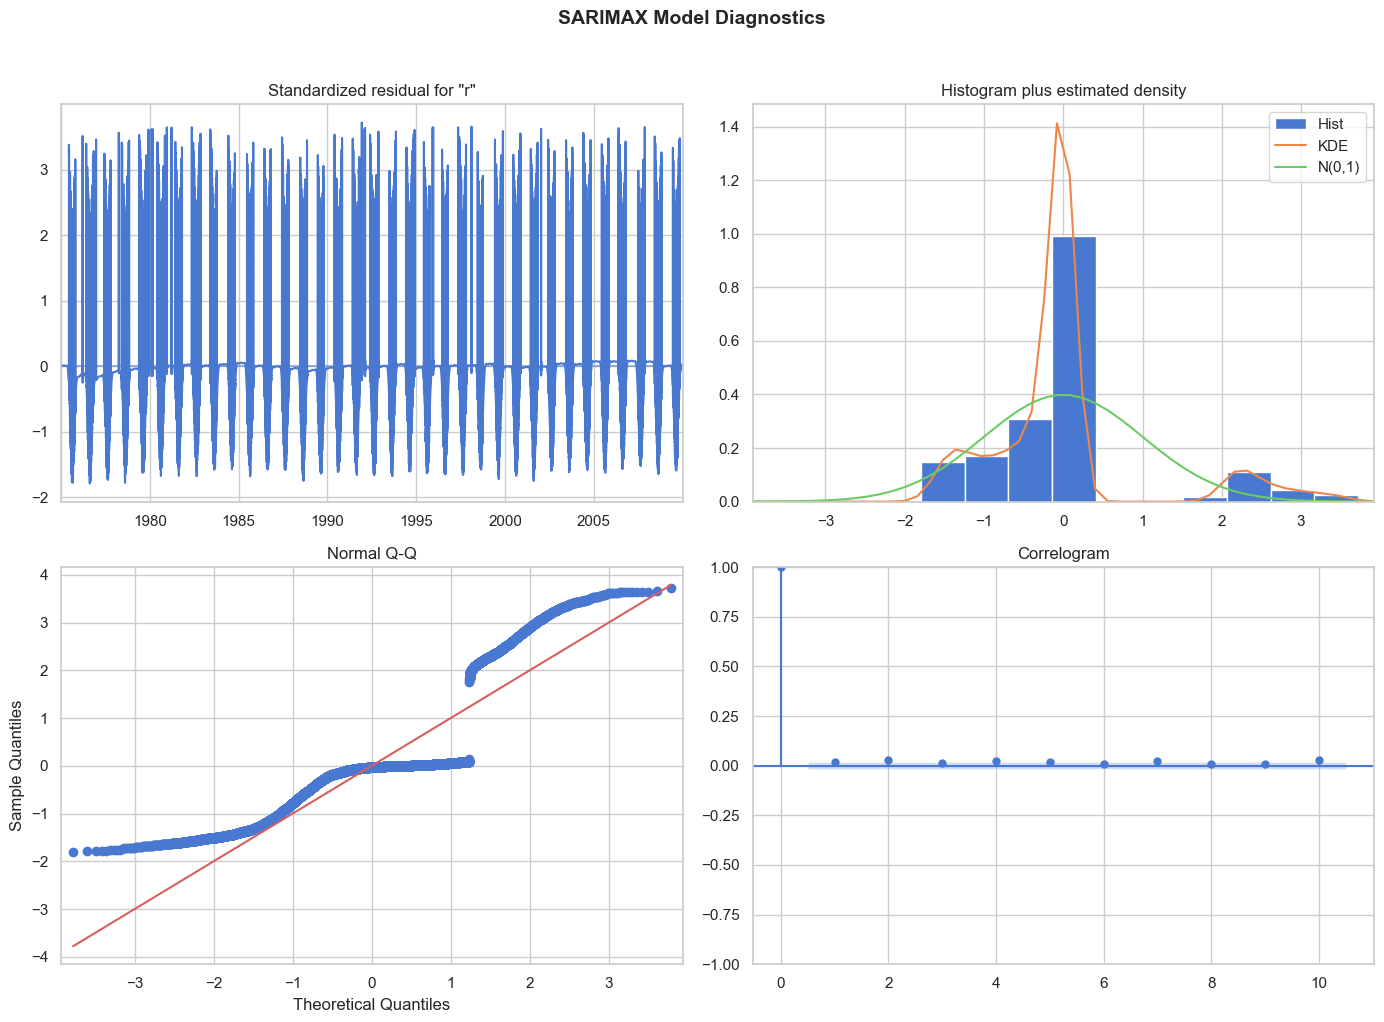

In [13]:
# Model diagnostics
print("\nModel Coefficients:")
print(model_fit.summary().tables[1])

# Plot diagnostics
fig = model_fit.plot_diagnostics(figsize=(14, 10))
plt.suptitle("SARIMAX Model Diagnostics", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## Predictions and Evaluation

Generate predictions for train, validation, and test sets. Convert continuous predictions to binary using an optimal threshold.

In [14]:
# In-sample predictions (training set)
y_train_pred_continuous = model_fit.fittedvalues

# Out-of-sample forecasts for validation and test sets
# We need to forecast step by step or use dynamic forecasting

# Forecast validation period
forecast_val = model_fit.get_forecast(
    steps=len(y_val),
    exog=fourier_val
)
y_val_pred_continuous = forecast_val.predicted_mean

# For test set, we need to extend the model with validation data
# Create combined series for refitting
y_train_val = pd.concat([y_train, y_val])
fourier_train_val = pd.concat([fourier_train, fourier_val])

# Refit model on train+val for test forecasting
model_extended = SARIMAX(
    y_train_val,
    exog=fourier_train_val,
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_extended_fit = model_extended.fit(disp=False, maxiter=500)

# Forecast test period
forecast_test = model_extended_fit.get_forecast(
    steps=len(y_test),
    exog=fourier_test
)
y_test_pred_continuous = forecast_test.predicted_mean

print("Predictions generated successfully!")
print(f"  Train predictions: {len(y_train_pred_continuous)}")
print(f"  Validation predictions: {len(y_val_pred_continuous)}")
print(f"  Test predictions: {len(y_test_pred_continuous)}")

Predictions generated successfully!
  Train predictions: 12784
  Validation predictions: 3652
  Test predictions: 1827


In [15]:
# Find optimal threshold using validation set ROC curve
# Clip predictions to [0, 1] range (SARIMA can predict outside this range)
y_train_proba = np.clip(y_train_pred_continuous.values, 0, 1)
y_val_proba = np.clip(y_val_pred_continuous.values, 0, 1)
y_test_proba = np.clip(y_test_pred_continuous.values, 0, 1)

# Find optimal threshold using Youden's J statistic on validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_proba)
j_scores = tpr_val - fpr_val
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds_val[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")
print(f"  TPR at optimal: {tpr_val[optimal_idx]:.4f}")
print(f"  FPR at optimal: {fpr_val[optimal_idx]:.4f}")

# Apply threshold to get binary predictions
y_train_pred = (y_train_proba >= optimal_threshold).astype(int)
y_val_pred = (y_val_proba >= optimal_threshold).astype(int)
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

Optimal threshold (Youden's J): 0.0987
  TPR at optimal: 0.9288
  FPR at optimal: 0.2638


In [16]:
# Calculate metrics
train_auc = roc_auc_score(y_train, y_train_proba)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

val_auc = roc_auc_score(y_val, y_val_proba)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("=" * 60)
print("SARIMAX RESULTS")
print("=" * 60)
print(f"\n{'Set':<12} {'Accuracy':>10} {'F1 Score':>10} {'ROC AUC':>10}")
print("-" * 45)
print(f"{'Train':<12} {train_acc:>10.4f} {train_f1:>10.4f} {train_auc:>10.4f}")
print(f"{'Validation':<12} {val_acc:>10.4f} {val_f1:>10.4f} {val_auc:>10.4f}")
print(f"{'Test':<12} {test_acc:>10.4f} {test_f1:>10.4f} {test_auc:>10.4f}")

SARIMAX RESULTS

Set            Accuracy   F1 Score    ROC AUC
---------------------------------------------
Train            0.7431     0.4363     0.8777
Validation       0.7555     0.4316     0.8827
Test             0.7761     0.5054     0.8899


In [17]:
# Classification reports
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - VALIDATION SET")
print("=" * 60)
print(classification_report(y_val, y_val_pred, target_names=["No Rain (0)", "Rain (1)"]))

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT - TEST SET")
print("=" * 60)
print(classification_report(y_test, y_test_pred, target_names=["No Rain (0)", "Rain (1)"]))


CLASSIFICATION REPORT - VALIDATION SET
              precision    recall  f1-score   support

 No Rain (0)       0.99      0.74      0.84      3287
    Rain (1)       0.28      0.93      0.43       365

    accuracy                           0.76      3652
   macro avg       0.64      0.83      0.64      3652
weighted avg       0.92      0.76      0.80      3652


CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

 No Rain (0)       0.99      0.76      0.86      1601
    Rain (1)       0.35      0.92      0.51       226

    accuracy                           0.78      1827
   macro avg       0.67      0.84      0.68      1827
weighted avg       0.91      0.78      0.81      1827



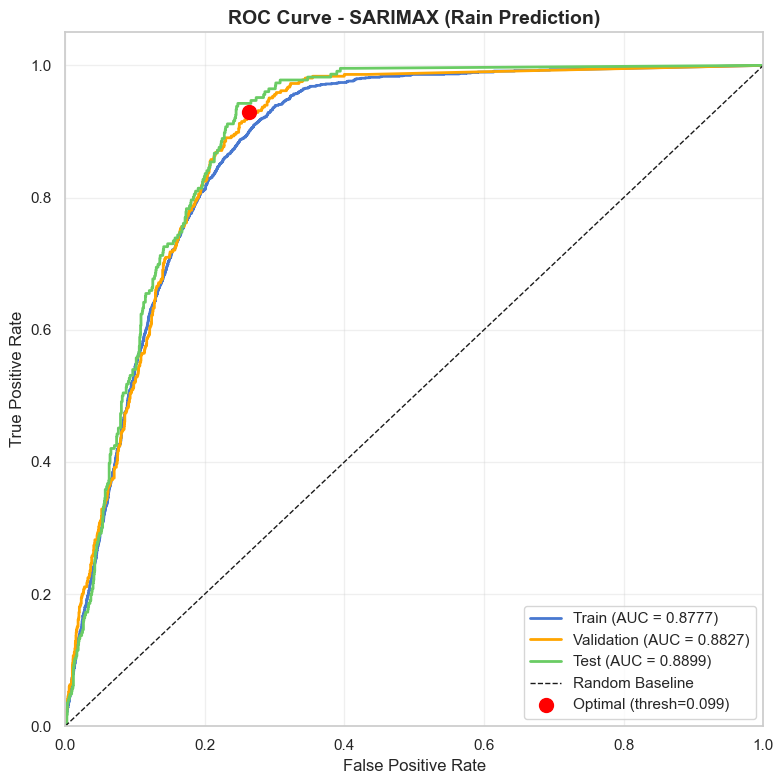

In [18]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 8))

# Train ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
ax.plot(fpr_train, tpr_train, "b-", lw=2, label=f"Train (AUC = {train_auc:.4f})")

# Validation ROC
ax.plot(fpr_val, tpr_val, "orange", lw=2, label=f"Validation (AUC = {val_auc:.4f})")

# Test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
ax.plot(fpr_test, tpr_test, "g-", lw=2, label=f"Test (AUC = {test_auc:.4f})")

# Random baseline
ax.plot([0, 1], [0, 1], "k--", lw=1, label="Random Baseline")

# Mark optimal threshold point on validation curve
ax.scatter(fpr_val[optimal_idx], tpr_val[optimal_idx], 
           color='red', s=100, zorder=5, label=f'Optimal (thresh={optimal_threshold:.3f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curve - SARIMAX (Rain Prediction)", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

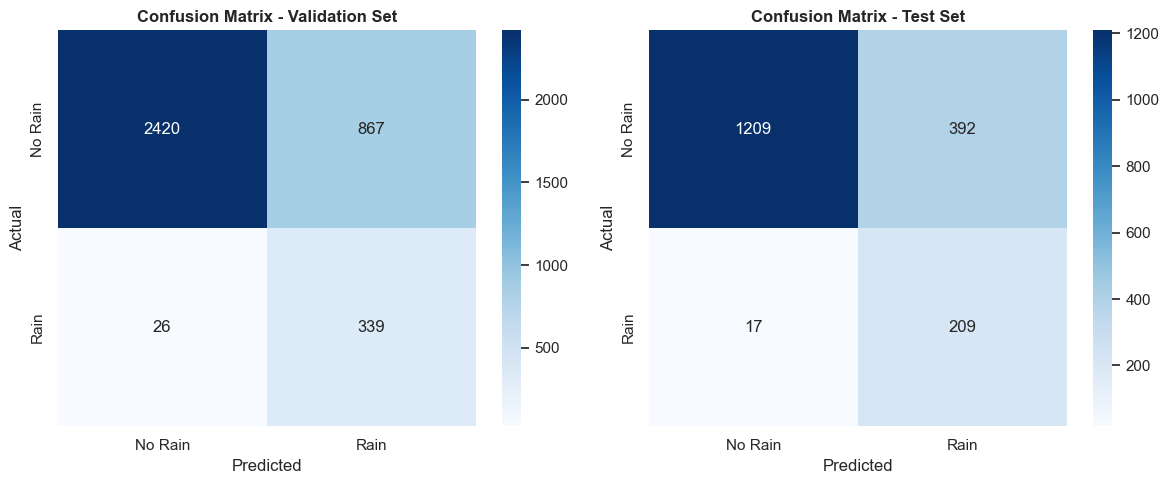

In [19]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (y_true, y_pred_set, title) in zip(
    axes, [(y_val, y_val_pred, "Validation"), (y_test, y_test_pred, "Test")]
):
    cm = confusion_matrix(y_true, y_pred_set)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
        xticklabels=["No Rain", "Rain"],
        yticklabels=["No Rain", "Rain"],
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix - {title} Set", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

## Forecast Visualization

Visualize the model predictions compared to actual values.

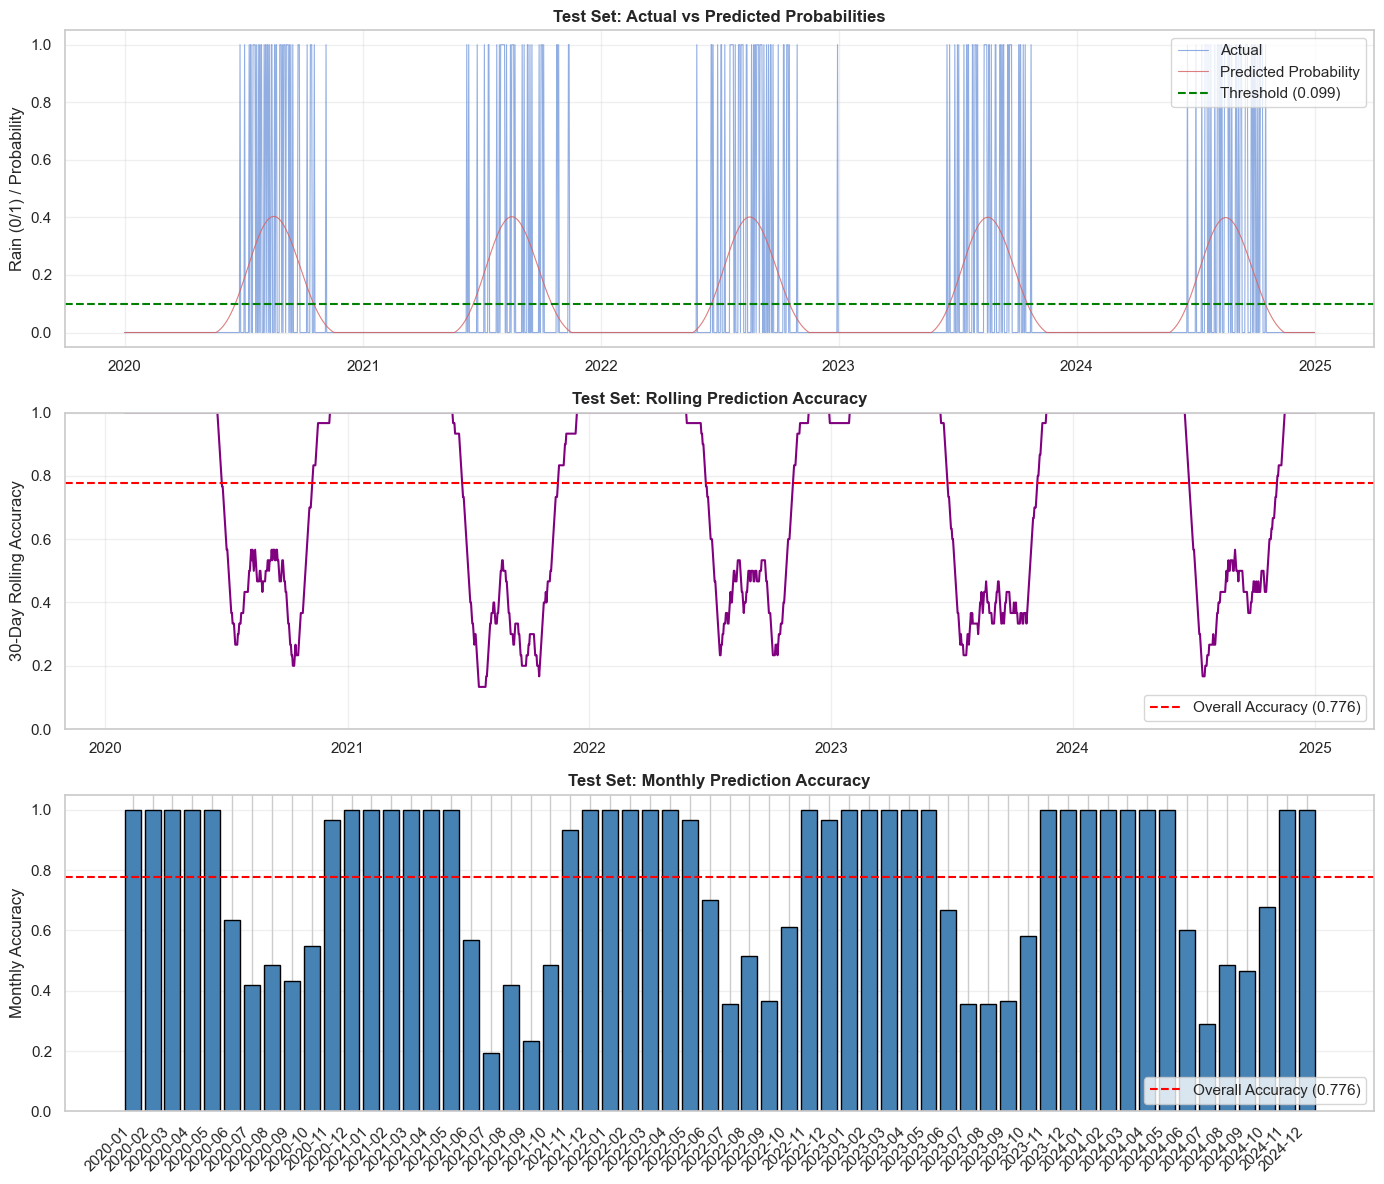

In [20]:
# Plot predictions over time for test set
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Test set - actual vs predicted probabilities
ax = axes[0]
ax.plot(y_test.index, y_test.values, 'b-', alpha=0.6, label='Actual', linewidth=0.8)
ax.plot(y_test.index, y_test_proba, 'r-', alpha=0.8, label='Predicted Probability', linewidth=0.8)
ax.axhline(y=optimal_threshold, color='green', linestyle='--', label=f'Threshold ({optimal_threshold:.3f})')
ax.set_ylabel('Rain (0/1) / Probability')
ax.set_title('Test Set: Actual vs Predicted Probabilities', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

# Rolling accuracy over test period (30-day window)
ax = axes[1]
correct = (y_test.values == y_test_pred).astype(int)
rolling_acc = pd.Series(correct, index=y_test.index).rolling(30).mean()
ax.plot(rolling_acc.index, rolling_acc.values, 'purple', linewidth=1.5)
ax.axhline(y=test_acc, color='red', linestyle='--', label=f'Overall Accuracy ({test_acc:.3f})')
ax.set_ylabel('30-Day Rolling Accuracy')
ax.set_title('Test Set: Rolling Prediction Accuracy', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
ax.set_ylim(0, 1)

# Monthly prediction accuracy
ax = axes[2]
monthly_acc = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred
}, index=y_test.index)
monthly_metrics = monthly_acc.groupby(monthly_acc.index.to_period('M')).apply(
    lambda x: (x['actual'] == x['predicted']).mean()
)
ax.bar(range(len(monthly_metrics)), monthly_metrics.values, color='steelblue', edgecolor='black')
ax.set_xticks(range(len(monthly_metrics)))
ax.set_xticklabels([str(p) for p in monthly_metrics.index], rotation=45, ha='right')
ax.axhline(y=test_acc, color='red', linestyle='--', label=f'Overall Accuracy ({test_acc:.3f})')
ax.set_ylabel('Monthly Accuracy')
ax.set_title('Test Set: Monthly Prediction Accuracy', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Store original SARIMAX results for later comparison
# (before running improved model which would overwrite variables)

original_model = {
    'name': 'SARIMAX (Fourier only)',
    'order': order,
    'n_features': fourier_train.shape[1],
    'model_fit': model_fit,
    'optimal_threshold': optimal_threshold,
    'train_acc': train_acc,
    'train_f1': train_f1,
    'train_auc': train_auc,
    'val_acc': val_acc,
    'val_f1': val_f1,
    'val_auc': val_auc,
    'test_acc': test_acc,
    'test_f1': test_f1,
    'test_auc': test_auc,
    'y_test_proba': y_test_proba.copy(),
    'y_test_pred': y_test_pred.copy(),
}

print("✓ Original SARIMAX results stored for comparison")
print(f"  Model: {original_model['name']}")
print(f"  Order: {original_model['order']}")
print(f"  Test AUC: {original_model['test_auc']:.4f}")

✓ Original SARIMAX results stored for comparison
  Model: SARIMAX (Fourier only)
  Order: (2, 0, 2)
  Test AUC: 0.8899


## Improved SARIMAX Model

Now let's improve the model by adding:
1. **More Fourier harmonics** (6 instead of 4) for better seasonal capture
2. **Meteorological exogenous variables** (temperature, humidity, pressure, cloud cover + lags)
3. **Higher ARIMA order** (3,0,3) based on ACF/PACF analysis

In [22]:
# Create Fourier features with MORE harmonics for better seasonal capture
N_HARMONICS_V2 = 6  # Increased from 4

fourier_train_v2 = create_fourier_features(y_train.index, period=365.25, n_harmonics=N_HARMONICS_V2)
fourier_val_v2 = create_fourier_features(y_val.index, period=365.25, n_harmonics=N_HARMONICS_V2)
fourier_test_v2 = create_fourier_features(y_test.index, period=365.25, n_harmonics=N_HARMONICS_V2)

print(f"Fourier features created ({N_HARMONICS_V2} harmonics = {N_HARMONICS_V2*2} features)")
print(f"  Train shape: {fourier_train_v2.shape}")
print(f"  Validation shape: {fourier_val_v2.shape}")
print(f"  Test shape: {fourier_test_v2.shape}")

Fourier features created (6 harmonics = 12 features)
  Train shape: (12784, 12)
  Validation shape: (3652, 12)
  Test shape: (1827, 12)


In [23]:
# Prepare exogenous meteorological features for SARIMAX
# These provide additional predictive power beyond just time patterns

# Select meteorological features
meteo_features = ['t2m', 'd2m', 'tcc', 'sp', 'rh']

# Create lagged features (yesterday's weather helps predict today's rain)
def create_lagged_features(df, features, lags=[1, 2, 3]):
    """Create lagged meteorological features."""
    result = df[features].copy()
    for lag in lags:
        for feat in features:
            result[f'{feat}_lag{lag}'] = df[feat].shift(lag)
    return result

# Create meteorological features
X_meteo_v2 = create_lagged_features(df, meteo_features, lags=[1, 2, 3])
X_meteo_v2 = X_meteo_v2.dropna()  # Remove rows with NaN from lagging

# Align indices - need to handle the first few days lost to lagging
# Get intersection with train/val/test indices
train_idx_v2 = y_train.index.intersection(X_meteo_v2.index)
val_idx_v2 = y_val.index.intersection(X_meteo_v2.index)
test_idx_v2 = y_test.index.intersection(X_meteo_v2.index)

# Adjust target series to match (drop first few days with NaN lags)
y_train_v2 = y_train.loc[train_idx_v2]
y_val_v2 = y_val.loc[val_idx_v2]
y_test_v2 = y_test.loc[test_idx_v2]

# Recreate Fourier features with aligned indices
fourier_train_v2 = create_fourier_features(train_idx_v2, period=365.25, n_harmonics=N_HARMONICS_V2)
fourier_val_v2 = create_fourier_features(val_idx_v2, period=365.25, n_harmonics=N_HARMONICS_V2)
fourier_test_v2 = create_fourier_features(test_idx_v2, period=365.25, n_harmonics=N_HARMONICS_V2)

# Split meteorological features
X_train_meteo_v2 = X_meteo_v2.loc[train_idx_v2]
X_val_meteo_v2 = X_meteo_v2.loc[val_idx_v2]
X_test_meteo_v2 = X_meteo_v2.loc[test_idx_v2]

# Combine Fourier + meteorological features
X_train_v2 = pd.concat([fourier_train_v2, X_train_meteo_v2], axis=1)
X_val_v2 = pd.concat([fourier_val_v2, X_val_meteo_v2], axis=1)
X_test_v2 = pd.concat([fourier_test_v2, X_test_meteo_v2], axis=1)

print(f"Combined exogenous features:")
print(f"  Fourier features: {fourier_train_v2.shape[1]}")
print(f"  Meteorological features: {X_train_meteo_v2.shape[1]}")
print(f"  Total: {X_train_v2.shape[1]} features")
print(f"\nAligned dataset sizes:")
print(f"  Train: {len(y_train_v2)} (dropped {len(y_train) - len(y_train_v2)} days for lagging)")
print(f"  Val: {len(y_val_v2)}")
print(f"  Test: {len(y_test_v2)}")

Combined exogenous features:
  Fourier features: 12
  Meteorological features: 20
  Total: 32 features

Aligned dataset sizes:
  Train: 12781 (dropped 3 days for lagging)
  Val: 3652
  Test: 1827


In [24]:
# Fit IMPROVED SARIMAX model with Fourier terms + meteorological features
import time

# ARIMA parameters - increased order for better fit
order_v2 = (3, 0, 3)  # Higher order ARIMA

print("=" * 70)
print("FITTING IMPROVED SARIMAX MODEL")
print("=" * 70)
print(f"\nOrder (p, d, q): {order_v2}")
print(f"Exogenous variables:")
print(f"  - Fourier harmonics: {N_HARMONICS_V2 * 2} features")
print(f"  - Meteorological: t2m, d2m, tcc, sp, rh + lags (1-3 days)")
print(f"  - Total: {X_train_v2.shape[1]} features")
print("\nFitting model... (this may take a few minutes)")

start_time = time.time()

# Fit the improved model with full feature set
model_v2 = SARIMAX(
    y_train_v2,
    exog=X_train_v2,
    order=order_v2,
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit_v2 = model_v2.fit(disp=False, maxiter=1000)
elapsed_time = time.time() - start_time

print(f"\n✓ Model fitted in {elapsed_time:.1f} seconds")
print(model_fit_v2.summary().tables[0])

FITTING IMPROVED SARIMAX MODEL

Order (p, d, q): (3, 0, 3)
Exogenous variables:
  - Fourier harmonics: 12 features
  - Meteorological: t2m, d2m, tcc, sp, rh + lags (1-3 days)
  - Total: 32 features

Fitting model... (this may take a few minutes)

✓ Model fitted in 5.6 seconds
                               SARIMAX Results                                
Dep. Variable:            rain_binary   No. Observations:                12781
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -1192.945
Date:                Tue, 06 Jan 2026   AIC                           2463.890
Time:                        09:55:56   BIC                           2754.650
Sample:                    01-04-1975   HQIC                          2561.123
                         - 12-31-2009                                         
Covariance Type:                  opg                                         



Improved Model Coefficients:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         -0.0935      0.015     -6.305      0.000      -0.123      -0.064
cos_1         -0.1269      0.015     -8.437      0.000      -0.156      -0.097
sin_2          0.0822      0.010      8.021      0.000       0.062       0.102
cos_2         -0.0112      0.010     -1.093      0.274      -0.031       0.009
sin_3         -0.0242      0.009     -2.719      0.007      -0.042      -0.007
cos_3          0.0115      0.011      1.090      0.276      -0.009       0.032
sin_4          0.0017      0.009      0.190      0.850      -0.016       0.020
cos_4         -0.0067      0.009     -0.747      0.455      -0.024       0.011
sin_5         -0.0035      0.009     -0.402      0.687      -0.021       0.014
cos_5          0.0048      0.009      0.537      0.591      -0.013       0.022
sin_6          0.0037 

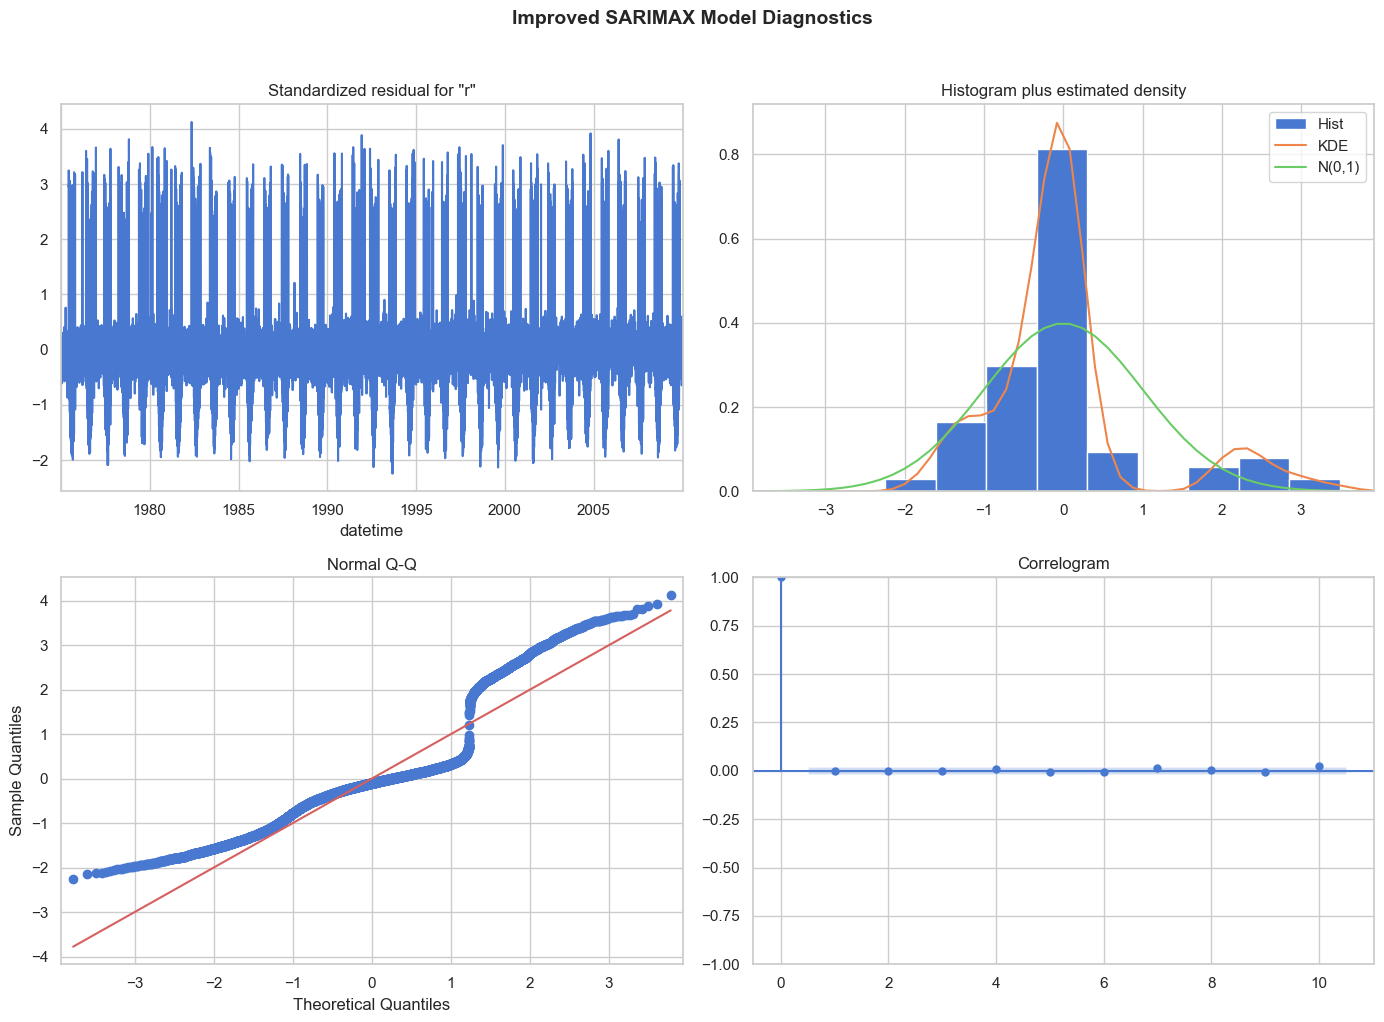

In [25]:
# Model diagnostics for improved model
print("\nImproved Model Coefficients:")
print(model_fit_v2.summary().tables[1])

# Plot diagnostics
fig = model_fit_v2.plot_diagnostics(figsize=(14, 10))
plt.suptitle("Improved SARIMAX Model Diagnostics", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

In [26]:
# Generate predictions for improved model
# In-sample predictions (training set)
y_train_pred_v2_continuous = model_fit_v2.fittedvalues

# Forecast validation period
forecast_val_v2 = model_fit_v2.get_forecast(
    steps=len(y_val_v2),
    exog=X_val_v2
)
y_val_pred_v2_continuous = forecast_val_v2.predicted_mean

# For test set, refit on train+val
y_train_val_v2 = pd.concat([y_train_v2, y_val_v2])
X_train_val_v2 = pd.concat([X_train_v2, X_val_v2])

print("Refitting model on train+val for test forecasting...")
model_extended_v2 = SARIMAX(
    y_train_val_v2,
    exog=X_train_val_v2,
    order=order_v2,
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_extended_fit_v2 = model_extended_v2.fit(disp=False, maxiter=1000)

# Forecast test period
forecast_test_v2 = model_extended_fit_v2.get_forecast(
    steps=len(y_test_v2),
    exog=X_test_v2
)
y_test_pred_v2_continuous = forecast_test_v2.predicted_mean

print("Predictions generated successfully!")
print(f"  Train predictions: {len(y_train_pred_v2_continuous)}")
print(f"  Validation predictions: {len(y_val_pred_v2_continuous)}")
print(f"  Test predictions: {len(y_test_pred_v2_continuous)}")

Refitting model on train+val for test forecasting...
Predictions generated successfully!
  Train predictions: 12781
  Validation predictions: 3652
  Test predictions: 1827


In [27]:
# Evaluate improved model
# Clip predictions to [0, 1] range
y_train_proba_v2 = np.clip(y_train_pred_v2_continuous.values, 0, 1)
y_val_proba_v2 = np.clip(y_val_pred_v2_continuous.values, 0, 1)
y_test_proba_v2 = np.clip(y_test_pred_v2_continuous.values, 0, 1)

# Find optimal threshold using Youden's J statistic on validation set
fpr_val_v2, tpr_val_v2, thresholds_val_v2 = roc_curve(y_val_v2, y_val_proba_v2)
j_scores_v2 = tpr_val_v2 - fpr_val_v2
optimal_idx_v2 = np.argmax(j_scores_v2)
optimal_threshold_v2 = thresholds_val_v2[optimal_idx_v2]

print(f"Optimal threshold (Youden's J): {optimal_threshold_v2:.4f}")

# Apply threshold
y_train_pred_v2 = (y_train_proba_v2 >= optimal_threshold_v2).astype(int)
y_val_pred_v2 = (y_val_proba_v2 >= optimal_threshold_v2).astype(int)
y_test_pred_v2 = (y_test_proba_v2 >= optimal_threshold_v2).astype(int)

# Calculate metrics
train_auc_v2 = roc_auc_score(y_train_v2, y_train_proba_v2)
train_acc_v2 = accuracy_score(y_train_v2, y_train_pred_v2)
train_f1_v2 = f1_score(y_train_v2, y_train_pred_v2)

val_auc_v2 = roc_auc_score(y_val_v2, y_val_proba_v2)
val_acc_v2 = accuracy_score(y_val_v2, y_val_pred_v2)
val_f1_v2 = f1_score(y_val_v2, y_val_pred_v2)

test_auc_v2 = roc_auc_score(y_test_v2, y_test_proba_v2)
test_acc_v2 = accuracy_score(y_test_v2, y_test_pred_v2)
test_f1_v2 = f1_score(y_test_v2, y_test_pred_v2)

print("\n" + "=" * 70)
print("IMPROVED SARIMAX RESULTS")
print("=" * 70)
print(f"\n{'Set':<12} {'Accuracy':>10} {'F1 Score':>10} {'ROC AUC':>10}")
print("-" * 45)
print(f"{'Train':<12} {train_acc_v2:>10.4f} {train_f1_v2:>10.4f} {train_auc_v2:>10.4f}")
print(f"{'Validation':<12} {val_acc_v2:>10.4f} {val_f1_v2:>10.4f} {val_auc_v2:>10.4f}")
print(f"{'Test':<12} {test_acc_v2:>10.4f} {test_f1_v2:>10.4f} {test_auc_v2:>10.4f}")

Optimal threshold (Youden's J): 0.1927

IMPROVED SARIMAX RESULTS

Set            Accuracy   F1 Score    ROC AUC
---------------------------------------------
Train            0.8173     0.5126     0.9109
Validation       0.8253     0.5023     0.9097
Test             0.8352     0.5657     0.9204


## Model Comparison: Original vs Improved SARIMAX

In [28]:
# Store improved model results
improved_model = {
    'name': 'SARIMAX (Fourier + Meteo)',
    'order': order_v2,
    'n_features': X_train_v2.shape[1],
    'model_fit': model_fit_v2,
    'optimal_threshold': optimal_threshold_v2,
    'train_acc': train_acc_v2,
    'train_f1': train_f1_v2,
    'train_auc': train_auc_v2,
    'val_acc': val_acc_v2,
    'val_f1': val_f1_v2,
    'val_auc': val_auc_v2,
    'test_acc': test_acc_v2,
    'test_f1': test_f1_v2,
    'test_auc': test_auc_v2,
    'y_test_proba': y_test_proba_v2.copy(),
    'y_test_pred': y_test_pred_v2.copy(),
}

# Comparison table
print("=" * 80)
print("MODEL COMPARISON: Original vs Improved SARIMAX")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metric': ['Order', 'N Features', 'Threshold', 
               'Val Accuracy', 'Val F1', 'Val AUC',
               'Test Accuracy', 'Test F1', 'Test AUC', 'AIC', 'BIC'],
    'Original SARIMAX': [
        str(original_model['order']), original_model['n_features'], f"{original_model['optimal_threshold']:.4f}",
        f"{original_model['val_acc']:.4f}", f"{original_model['val_f1']:.4f}", f"{original_model['val_auc']:.4f}",
        f"{original_model['test_acc']:.4f}", f"{original_model['test_f1']:.4f}", f"{original_model['test_auc']:.4f}",
        f"{original_model['model_fit'].aic:.1f}", f"{original_model['model_fit'].bic:.1f}"
    ],
    'Improved SARIMAX': [
        str(improved_model['order']), improved_model['n_features'], f"{improved_model['optimal_threshold']:.4f}",
        f"{improved_model['val_acc']:.4f}", f"{improved_model['val_f1']:.4f}", f"{improved_model['val_auc']:.4f}",
        f"{improved_model['test_acc']:.4f}", f"{improved_model['test_f1']:.4f}", f"{improved_model['test_auc']:.4f}",
        f"{improved_model['model_fit'].aic:.1f}", f"{improved_model['model_fit'].bic:.1f}"
    ]
})

print("\n" + comparison_df.to_string(index=False))

# Calculate improvements
print("\n" + "=" * 80)
print("IMPROVEMENT SUMMARY (Test Set)")
print("=" * 80)
acc_diff = improved_model['test_acc'] - original_model['test_acc']
f1_diff = improved_model['test_f1'] - original_model['test_f1']
auc_diff = improved_model['test_auc'] - original_model['test_auc']

print(f"\nAccuracy: {original_model['test_acc']:.4f} → {improved_model['test_acc']:.4f} ({'+' if acc_diff >= 0 else ''}{acc_diff:.4f})")
print(f"F1 Score: {original_model['test_f1']:.4f} → {improved_model['test_f1']:.4f} ({'+' if f1_diff >= 0 else ''}{f1_diff:.4f})")
print(f"ROC AUC:  {original_model['test_auc']:.4f} → {improved_model['test_auc']:.4f} ({'+' if auc_diff >= 0 else ''}{auc_diff:.4f})")

MODEL COMPARISON: Original vs Improved SARIMAX

       Metric Original SARIMAX Improved SARIMAX
        Order        (2, 0, 2)        (3, 0, 3)
   N Features                8               32
    Threshold           0.0987           0.1927
 Val Accuracy           0.7555           0.8253
       Val F1           0.4316           0.5023
      Val AUC           0.8827           0.9097
Test Accuracy           0.7761           0.8352
      Test F1           0.5054           0.5657
     Test AUC           0.8899           0.9204
          AIC           3292.8           2463.9
          BIC           3389.8           2754.7

IMPROVEMENT SUMMARY (Test Set)

Accuracy: 0.7761 → 0.8352 (+0.0591)
F1 Score: 0.5054 → 0.5657 (+0.0602)
ROC AUC:  0.8899 → 0.9204 (+0.0304)


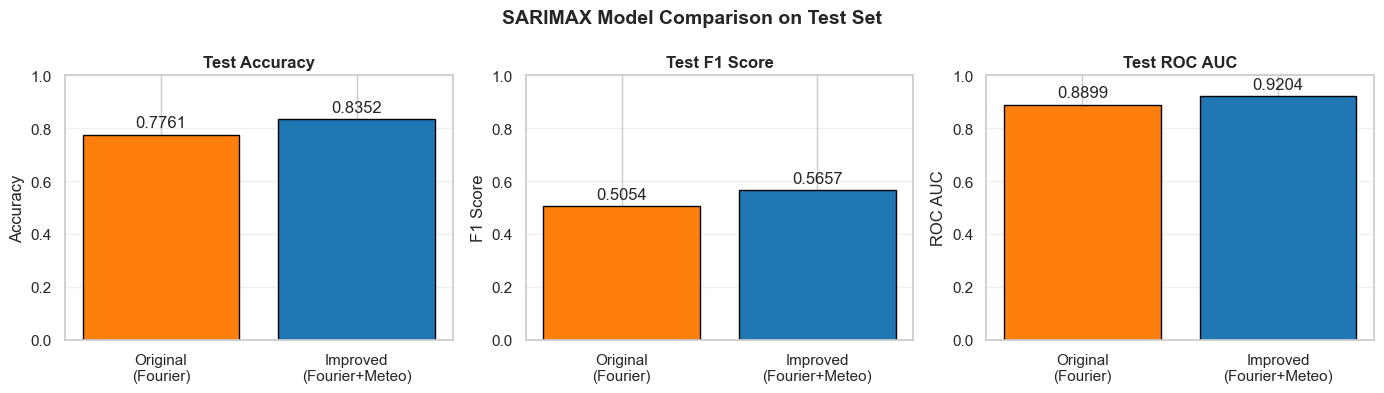

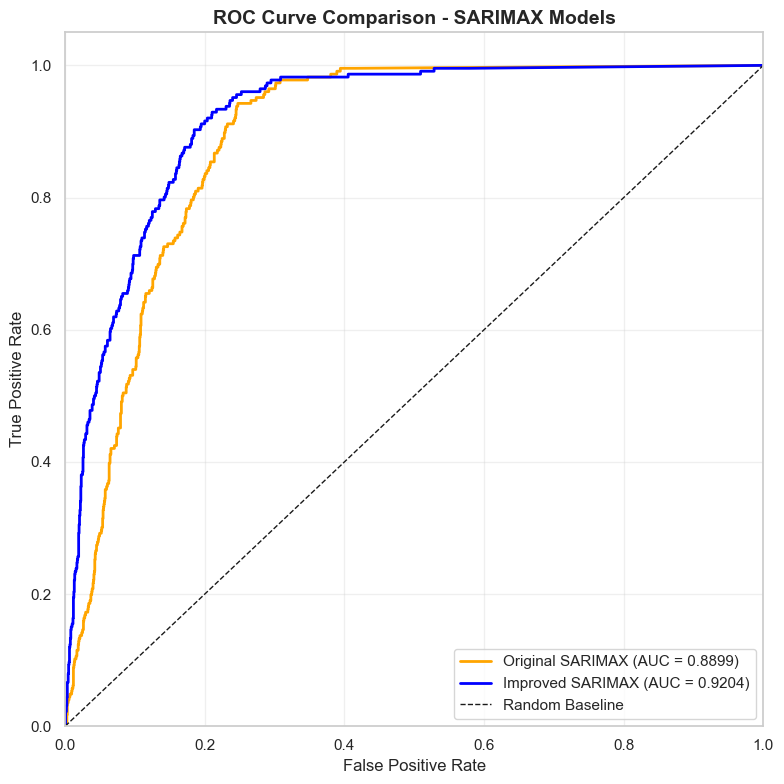

In [29]:
# Visual comparison of models
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

metrics = ['Accuracy', 'F1 Score', 'ROC AUC']
original_vals = [original_model['test_acc'], original_model['test_f1'], original_model['test_auc']]
improved_vals = [improved_model['test_acc'], improved_model['test_f1'], improved_model['test_auc']]

for ax, metric, orig, imp in zip(axes, metrics, original_vals, improved_vals):
    x = np.arange(2)
    bars = ax.bar(x, [orig, imp], color=['#ff7f0e', '#1f77b4'], edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(['Original\n(Fourier)', 'Improved\n(Fourier+Meteo)'])
    ax.set_ylabel(metric)
    ax.set_title(f'Test {metric}', fontweight='bold')
    ax.set_ylim(0, 1)
    ax.bar_label(bars, fmt='%.4f', padding=3)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('SARIMAX Model Comparison on Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ROC curve comparison
fig, ax = plt.subplots(figsize=(8, 8))

# Original model ROC
fpr_orig, tpr_orig, _ = roc_curve(y_test, original_model['y_test_proba'])
ax.plot(fpr_orig, tpr_orig, 'orange', lw=2, 
        label=f"Original SARIMAX (AUC = {original_model['test_auc']:.4f})")

# Improved model ROC
fpr_imp, tpr_imp, _ = roc_curve(y_test_v2, improved_model['y_test_proba'])
ax.plot(fpr_imp, tpr_imp, 'blue', lw=2, 
        label=f"Improved SARIMAX (AUC = {improved_model['test_auc']:.4f})")

# Random baseline
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Baseline')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curve Comparison - SARIMAX Models", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
# Final Summary
print("=" * 80)
print("PRECIPITATION PREDICTION - FINAL SUMMARY")
print("=" * 80)

print(f"\nData:")
print(f"  Source: ERA5 Reanalysis - Bissau, Guinea-Bissau")
print(f"  Period: {df.index.min().date()} to {df.index.max().date()}")
print(f"  Total samples: {len(df):,} days")
print(f"  Target: Binary rain classification (tp > {RAIN_THRESHOLD} mm)")

print(f"\n{'─' * 80}")
print("MODEL 1: Original SARIMAX (Fourier seasonality only)")
print(f"{'─' * 80}")
print(f"  Order: {original_model['order']}")
print(f"  Features: {original_model['n_features']} Fourier terms")
print(f"  Test Results: Acc={original_model['test_acc']:.4f}, F1={original_model['test_f1']:.4f}, AUC={original_model['test_auc']:.4f}")

print(f"\n{'─' * 80}")
print("MODEL 2: Improved SARIMAX (Fourier + Meteorological)")
print(f"{'─' * 80}")
print(f"  Order: {improved_model['order']}")
print(f"  Features: {improved_model['n_features']} (Fourier + t2m, d2m, tcc, sp, rh with lags)")
print(f"  Test Results: Acc={improved_model['test_acc']:.4f}, F1={improved_model['test_f1']:.4f}, AUC={improved_model['test_auc']:.4f}")

print(f"\n{'─' * 80}")
best = "Improved" if improved_model['test_auc'] > original_model['test_auc'] else "Original"
print(f"BEST MODEL: {best} SARIMAX")
print(f"{'─' * 80}")

PRECIPITATION PREDICTION - FINAL SUMMARY

Data:
  Source: ERA5 Reanalysis - Bissau, Guinea-Bissau
  Period: 1975-01-01 to 2024-12-31
  Total samples: 18,263 days
  Target: Binary rain classification (tp > 0.1 mm)

────────────────────────────────────────────────────────────────────────────────
MODEL 1: Original SARIMAX (Fourier seasonality only)
────────────────────────────────────────────────────────────────────────────────
  Order: (2, 0, 2)
  Features: 8 Fourier terms
  Test Results: Acc=0.7761, F1=0.5054, AUC=0.8899

────────────────────────────────────────────────────────────────────────────────
MODEL 2: Improved SARIMAX (Fourier + Meteorological)
────────────────────────────────────────────────────────────────────────────────
  Order: (3, 0, 3)
  Features: 32 (Fourier + t2m, d2m, tcc, sp, rh with lags)
  Test Results: Acc=0.8352, F1=0.5657, AUC=0.9204

────────────────────────────────────────────────────────────────────────────────
BEST MODEL: Improved SARIMAX
───────────────────